<img align="left" src =https://upload.wikimedia.org/wikipedia/commons/2/22/Dark_Energy_Survey_logo.jpg width=150 style="padding: 10px"> <br>

<b>ACT Cluster x Redmagic Cluster correlation functions</b> <br>
Contact author: <i>Jim Annis</i> <br>
Last verified to run: <i>2022-01-17</i> <br>
Targeted  level: <i>Cluster Cosmology Team</i> <br>
 


 # 1. Introduction

 At fixed mass the standard assumption is that the mass profile is on average the same.
 1. For a given mass bin, I can separate the clusters into two groups with random selection and their mass profile is the same.
 2. For a given mass bin, if I separate the clusters on a secondary characteristic, like stellar mass, then the mass profile will be same in both classes
    1. technically true if stellar mass is uncorrelated with mass
    2. Of course, if a separate the mass bin into two sub-mass bins, the mass profile will change.
    3. To the extent stellar mass is perfectly correlated with mass, separating the mass bin on stellar mass will reproduce the splitting on mass.
    4. To the extent the stellar mass is correlated with mass with coeffifient r, separating the mass bin on stellas mass will produce a lesser effect than r=1.
3. For a given mass bin, if I separate the clusters on stellar mass, then separate on lambda, I can work out $r_{sm}$ and $r_{\lambda}$.

That means the program goes as follows.
1. For the ACT clusters, compute the 4 z-bin cl-gal redmagic $w_{cl-rm}$.
2. For the ACT clusters, separate into two bins based on Y, compute the $w_{cl-rm}$.
3. For the ACT clusters, separate into two bins based on $\lambda$, compute the $w_{cl-rm}$.
4. For the ACT clusters, separate into two bins based on $\mu_\star$, compute the $w_{cl-rm}$.
5. For the ACT clusters, separate into two bins based on $\mu_\star$, break each of those bins into two bins on $\lmabda$, compute the $w_{cl-rm}$.

The meaning of each step is:
1. For a mass bin, compute $w_{cl-rm}$.
2. Break into two mass bins, see how much the $w_{cl-rm}$ vary.
3. Use stellar mass to break into bins, see how much less $w_{cl-rm}$ varies.
4. Use galaxy count to break into bins, see how much less $w_{cl-rm}$ varies.
5. Use stellar mass to break into 2 bins, use galaxy count to then break into four bins, watch $w_{cl-rm}$.

## 1.1 Package Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.set_loglevel("info") # magic! Fantastic- it gets rid of the extensive debugging messages

import fitsio
import astropy.units as u
import pandas as pd
import treecorr as tc
import seaborn as sns
from astropy.cosmology import FlatLambdaCDM

from dark_emulator import model_hod
#

## 1.2 Data Location

In [2]:
data_path = '/data/des70.a/data/araina/redmagic/'   # des70
data_path = '/Users/annis/Code/dark_emulator/anmol/data/' # JTA laptop

In [3]:
redmagic_filename = 'y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_redmagic_highdens.fit'  
randoms_filename = 'y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_redmagic_highdens_randoms.fit'

# these have been turned into pickles
redmagic_filename = 'redmagic_catalog_galaxies.pkl'
randoms_filename = 'redmagic_catalog_randoms.pkl' 

act_filename = 'act_catalog_clusters.pkl'


## 1.3 Control variables

In [4]:
# based on DES Y3 g-g and g-shear cosmology papers, the redshift bins for the redmagic galaxies
zbins = [ [0.15,0.35], [0.35, 0.5], [0.5, 0.65], [0.65, 0.80]  ]

# create redmagic pickles
create_rm_data_vectors = False
#create_rm_data_vectors = True

# create act pickles
create_act_pickles = False
#create_act_pickles = True

create_cl_data_vectors = False

## 1.4 Auto and cross correlation functions (Code)

In [5]:
def xi_in_bin(df_gal, df_rand, zbin=[]):
    
    '''
    This function calls the treecorr library to compute 
    correlation functions in a given bin using a galaxy
    and a random sample.
    '''
    
    zmin = zbin[0]
    zmax = zbin[1]
    
    df_gal = df_gal[(df_gal['z']>zmin)&(df_gal['z']<zmax)]
    df_rand = df_rand[(df_rand['z']>zmin)&(df_rand['z']<zmax)]
    
    galaxies = tc.Catalog(ra=df_gal['ra'][:], dec=df_gal['dec'][:], ra_units='degrees', dec_units='degrees')
    randoms = tc.Catalog(ra=df_rand['ra'][:], dec=df_rand['dec'][:], ra_units='degrees', dec_units='degrees')
    
    print('-------------------------------------------------------------------')
    print('computing ' + str(len(df_gal)) + ' galaxies and '
         + str(len(df_rand)) + ' randoms in zbin [' + str(zmin) + ',' + str(zmax) + ']')
    print('-------------------------------------------------------------------')
    
    #theta_min, theta_max = do_cosmology(zbin,np.asarray([0.1, 200.]), 'angle')
    theta_min, theta_max = .3/60., 300./60.
    nbins = 25
    
    gg = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')
    gr = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')
    rr = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')
    
    gg.process(galaxies, num_threads=5)
    gr.process(galaxies, randoms, num_threads=5)
    rr.process(randoms, num_threads=5)
    
    xi,varxi = gg.calculateXi(rr,gr)
    theta = np.exp(gg.logr)
      
    return xi, varxi, theta

def cross_xi_in_bin(df_cl, df_gal, df_rand, zbin=[], lbin=[], lname="lam"):
    
    '''
    This function calls the treecorr library to compute 
    correlation functions in a given bin using a galaxy
    and a random sample.
    '''
    
    zmin = zbin[0]
    zmax = zbin[1]
    lmin = lbin[0]
    lmax = lbin[1]
    
    df_cl = df_cl[(df_cl['z']>=zmin)&(df_cl['z']<zmax) & (df_cl[lname]>=lmin) & (df_cl[lname]<lmax)]
    df_gal = df_gal[(df_gal['z']>=zmin)&(df_gal['z']<zmax)]
    df_rand = df_rand[(df_rand['z']>=zmin)&(df_rand['z']<zmax)]
    
    print('--------------------------------------------------------------------------------------------------')
    print('computing ' + str(len(df_cl)) + ' clusters in ' + lname +' [' + str(lmin) + ',' + str(lmax)
         + '] and ' + str(len(df_gal)) + ' galaxies and '
         + str(len(df_rand)) + ' randoms in zbin [' + str(zmin) + ',' + str(zmax) + ']')
    print('--------------------------------------------------------------------------------------------------')
    
    clusters = tc.Catalog(ra=df_cl['ra'][:], dec=df_cl['dec'][:], ra_units='degrees', dec_units='degrees')
    galaxies = tc.Catalog(ra=df_gal['ra'][:], dec=df_gal['dec'][:], ra_units='degrees', dec_units='degrees')
    randoms = tc.Catalog(ra=df_rand['ra'][:], dec=df_rand['dec'][:], ra_units='degrees', dec_units='degrees')
    
    #theta_min, theta_max = do_cosmology(zbin,np.asarray([0.1, 200.]), 'angle')
    theta_min, theta_max = .3/60., 300./60.
    nbins = 25
    
    gg = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')
    gr = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')
    rr = tc.NNCorrelation(min_sep = theta_min, max_sep = theta_max, nbins=nbins, sep_units = 'degrees')
    
    gg.process(galaxies, clusters, num_threads=5)
    gr.process(galaxies, randoms, num_threads=5)
    rr.process(randoms, num_threads=5)
    
    xi,varxi = gg.calculateXi(rr,gr)
    theta = np.exp(gg.logr)
      
    return xi, varxi, theta

# 2.  Redmagic Catalogs

## 2.1 Redmagic data loading functions

In [6]:
def load_redmagic(filename, ftype="galaxy"):
    
    '''    
    This function reads the pickled redmagic galaxy and random
    data pandas dataframes 
    '''
    
    df = pd.read_pickle(filename)
    return df




## 2.2 Build Redmagic autocorrelation datavectors

In [7]:
def create_redmagic_datavector(zbins) :
    df_gal = load_redmagic(data_path+redmagic_filename, ftype='galaxy')
    df_rand = load_redmagic(data_path+randoms_filename, ftype='randoms')

    for zbin in zbins :
        zavg = (zbin[0]+zbin[1])/2.
        xi,varxi,theta = xi_in_bin(df_gal, df_rand, zbin=zbin)
        df = pd.DataFrame({"wp":xi, "varwp":varxi, "theta":theta})
        filename = data_path + "wp_redmagic_{:3.2f}.pkl".format(zavg)
        print("writing to {:s}".format(filename))
        df.to_pickle(filename)

if create_rm_data_vectors:
    create_redmagic_datavector(zbins)
#

## 2.3 Read Redmagic autocorrelation datavectors

In [8]:
def read_redmagic_datavector(zbins) :
    wp_redmagic = dict()
    for zbin in zbins :
        zavg = (zbin[0]+zbin[1])/2.
        zavg = "{:3.2f}".format(zavg)
        filename = data_path + "wp_redmagic_{}.pkl".format(zavg)
        print("reading {:s}".format(filename))
        df = pd.read_pickle(filename)
        # convert theta from degrees to arcminutes
        df["theta"] = df["theta"]*60.
        wp_redmagic[zavg] = df
    return wp_redmagic

wp_redmagic = read_redmagic_datavector(zbins)

reading /Users/annis/Code/dark_emulator/anmol/data/wp_redmagic_0.25.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_redmagic_0.42.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_redmagic_0.57.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_redmagic_0.73.pkl


## 2.4 Plot Redmagic autocorrelation datavectors

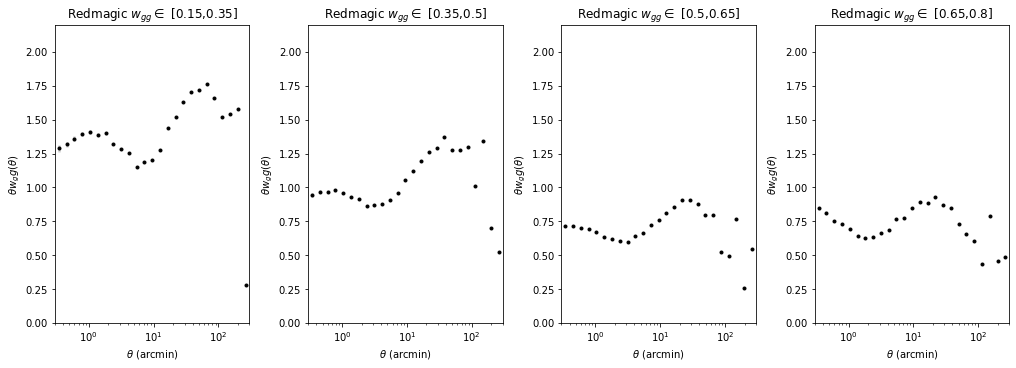

In [9]:
def plot_wp(wp_redmagic, zbins) :

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14, 5), constrained_layout=True)
    
    for i in range(0,len(zbins)) :
        zbin = zbins[i]
        zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)
        
        df = wp_redmagic[zavg]
        wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
        varwp = varwp*theta
        wp    =    wp*theta
    
        ax[i].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
            elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))
        ax[i].set_xlim(0.3,300)
        ax[i].set_ylim(0,2.2)
        ax[i].set_xscale('log')
        ax[i].set_title(r'Redmagic $w_{gg} \in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']')
        ax[i].set_xlabel(r'$\theta$ (arcmin)')
        ax[i].set_ylabel(r'$\theta w_gg(\theta)$ ')

plot_wp(wp_redmagic, zbins)

Compare those plots with the plots in, for example, "Dark Energy Survey Year 3 results: Galaxy clustering and systematics treatment for lens galaxy samples", at __[Rodríguez-Monroy, Weaverdyck, Elvin-Poole, Crocce, Carnero Rosell et al.](https://arxiv.org/pdf/2105.13540.pdf)__

# 3. ACT Cluster catalog

ACT DR5 SZ cluster catalogs
link: https://lambda.gsfc.nasa.gov/product/act/actpol_dr5_szcluster_catalog_info.cfm

Download "DR5 Cluster Catalog" and "DR5 Survey Mask".

The paper is many places, but https://lss.fnal.gov/archive/2020/pub/fermilab-pub-20-458-ae.pdf


## 3.1 Build ACT catalog pickle

In [10]:
def create_act(filename, ftype = 'cluster'):
    
    '''    
    This function converts the redmagic galaxy and random
    data into pandas dataframe for easy application of 
    various cuts
    '''
    
    if ftype == 'cluster':
        columns = ['ra', 'dec', 'z', 'Y', 
                   'DESY3', 'match_rm', 'lam', 
                   'Camira', 'match_cam','n_mem',
                   'snr']
        f = fitsio.FITS(filename)
        df = pd.DataFrame(np.stack((f[1]['raDeg'][:], f[1]['decDeg'][:], f[1]['redshift'][:], f[1]['y_c'][:], 
                                    f[1]['footprint_DESY3'][:],  f[1]['RMDESY3'][:], f[1]['RMDESY3_LAMBDA_CHISQ'][:], 
                                    f[1]['footprint_HSCs19a'][:],  f[1]['CAMIRA'][:], f[1]['CAMIRA_N_mem'][:],
                                    f[1]['fixed_SNR'][:]
                                    ), axis=-1), columns = columns)
        print("writing " + data_path+"act_catalog_clusters.pkl")
        df.to_pickle(data_path+"act_catalog_clusters.pkl")
     
if create_act_pickles:
    create_act(data_path+"DR5_cluster-catalog_v1.1.fits")
        
#

## 3.2 Load ACT catalog pickle and make pure sample

In [11]:
# Tae (Jan 13, 2022 DES Cl-Cos meeting) gives 0.15 < z < 0.7 and fixed_snr > 5.5 as a pure sample of ACT clusters
# We'll adopt the fixed_snr cut
def load_act_des(filename) :
    df = pd.read_pickle(filename)
    df = df[ (df['snr'] > 5.5) & (df['match_rm']== 1)]
    return df

df_cl = load_act_des(data_path+act_filename)    

## 3.3 Plot the redshift and Y distribution

We chose a cut that separates the catalog into lower and higher masses

55 %  below cut


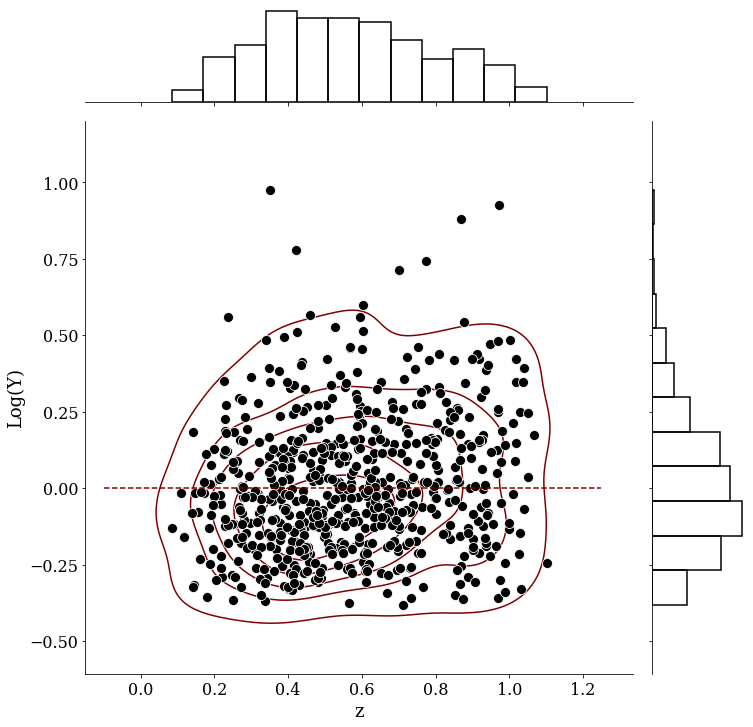

In [12]:
y_cut = 1.0
ax = sns.jointplot( x=df_cl.z, y=np.log10(df_cl.Y) ,  color="k", s=100,
                  marginal_kws=dict(bins=12, fill=False, color="k"), height=10)
ax.plot_joint(sns.kdeplot, color="maroon", zorder=0, levels=6)
plt.plot([-0.1,1.25],[np.log10(y_cut), np.log10(y_cut)], linestyle="dashed", c="maroon")
ax.ax_joint.set_ylabel(r'Log(Y)', fontsize=18, fontfamily="serif")
ax.ax_joint.set_xlabel(r'z', fontsize=18, fontfamily="serif")
for tick in ax.ax_joint.get_xticklabels():
    tick.set_fontfamily("serif"); tick.set_size(16)
for tick in ax.ax_joint.get_yticklabels():
    tick.set_fontfamily("serif"); tick.set_size(16)


#sns.histplot(df_cl, x="z")
x=df_cl[df_cl['Y']<y_cut]; 
print ( "{:.0f} %  below cut".format(100*x.size/df_cl[df_cl['Y']<1000].size))

### 3.3.1 Chose the Y bins

We choose three bins in Y_c:
-  bin 0: $Y_c \in $ [0,10]. The whole catalog
-  bin 1: $Y_c \in $ [0,$\phantom{0}$2]. A low mass bin with the bulk of the clusters
-  bin 2: $Y_c \in $ [2,10]. A high  mass bin 

In [13]:
y_bins = [ [0,10], [0, 1], [1, 10]  ]

## 3.4 Create ACT cross-correlation data vectors


In [14]:
def create_act_datavector(zbins, y_bins, lname="Y") :
    df_cl = load_act_des(data_path+act_filename)
    df_gal = load_redmagic(data_path+redmagic_filename,  ftype='galaxy')
    df_rand = load_redmagic(data_path+randoms_filename, ftype='random')

    for zbin in zbins :
        bin_count = 0
        for y_bin in y_bins :
            zavg = (zbin[0]+zbin[1])/2.
            y_bin_name = bin_count
            
            xi,varxi,theta = cross_xi_in_bin(df_cl, df_gal, df_rand, zbin=zbin, lbin=y_bin, lname=lname)
            df = pd.DataFrame({"wp":xi, "varwp":varxi, "theta":theta})
            filename = data_path + "wp_act_{:3.2f}_{:1d}.pkl".format(zavg,y_bin_name)
            print("writing to {:s}".format(filename))
            df.to_pickle(filename)
            bin_count += 1


if create_cl_data_vectors:
    create_act_datavector(zbins,y_bins)
#

## 3.5 Read ACT cross-correlation data vectors

In [15]:
def read_act_datavector(zbins, y_bins) :
    wp_act = dict()
    for zbin in zbins :
        bin_count = 0   
        for y_bin in y_bins :
            zavg = (zbin[0]+zbin[1])/2.
            zavg = "{:3.2f}".format(zavg)
            y_bin_name = bin_count
            
            filename = data_path + "wp_act_{}_{}.pkl".format(zavg, y_bin_name)
            print("reading {:s}".format(filename))
            df = pd.read_pickle(filename)
            # convert theta from degrees to arcminutes
            df["theta"] = df["theta"]*60.
            wp_act[zavg, y_bin_name] = df
            bin_count += 1
    return wp_act

wp_act = read_act_datavector(zbins, y_bins)

reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.25_0.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.25_1.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.25_2.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.42_0.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.42_1.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.42_2.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.57_0.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.57_1.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.57_2.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.73_0.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.73_1.pkl
reading /Users/annis/Code/dark_emulator/anmol/data/wp_act_0.73_2.pkl


## 3.6 Plot the ACT-Redmagic cross-correlation data vectors

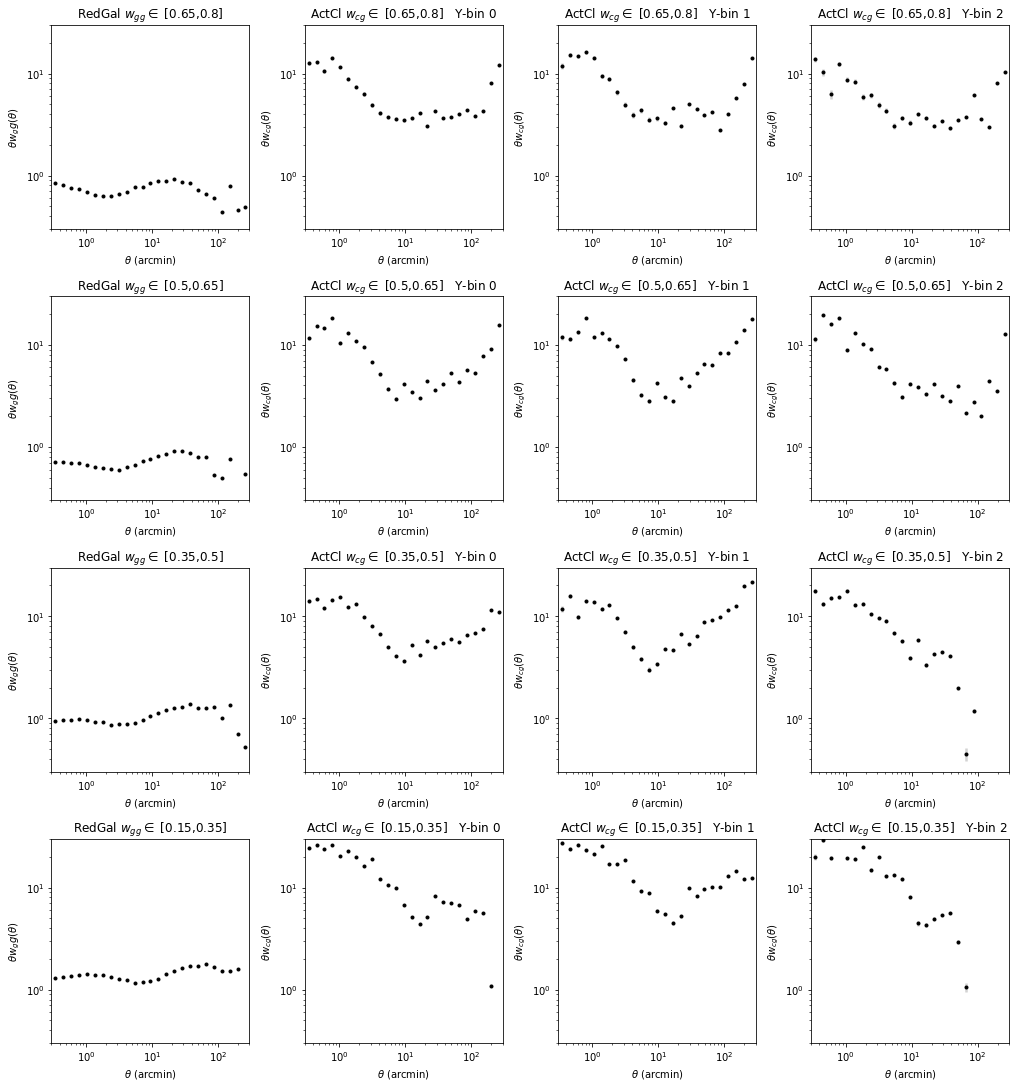

In [36]:
def plot_cross_wp(wp_redmagic, wp_act, zbins, y_bins) :

    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(14, 15), constrained_layout=True)
    
    for i in range(0,len(zbins)) :
        zbin = zbins[::-1][i]
        zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)        
        df = wp_redmagic[zavg]
        wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
        varwp = varwp*theta
        wp    =    wp*theta
    
        j=0
        ax[i][j].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
            elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))
        ax[i][j].set_xlim(0.3,300)
        ax[i][j].set_ylim(0.3,30)
        ax[i][j].set_xscale('log')
        ax[i][j].set_yscale('log')
        ax[i][j].set_title(r'RedGal $w_{gg} \in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']')
        ax[i][j].set_xlabel(r'$\theta$ (arcmin)')
        ax[i][j].set_ylabel(r'$\theta w_gg(\theta)$ ')
        
        bin_count = 0  
        for j in range(1,len(y_bins)+1) :
            zbin = zbins[::-1][i]
            zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)
            y_bin_name = bin_count
        
            df = wp_act[zavg,y_bin_name]
            wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
            varwp = varwp*theta
            wp    =    wp*theta
    
            ax[i][j].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
            elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))
            ax[i][j].set_xlim(0.3,300)
            ax[i][j].set_ylim(0.3,30)
            ax[i][j].set_xscale('log')
            ax[i][j].set_yscale('log')
            ax[i][j].set_title(r'ActCl $w_{cg} \in$' 
                                + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']' 
                               + "   Y-bin "+ str(y_bin_name) )
            ax[i][j].set_xlabel(r'$\theta$ (arcmin)')
            ax[i][j].set_ylabel(r'$\theta w_{cg}(\theta)$ ')
            bin_count += 1

plot_cross_wp(wp_redmagic, wp_act, zbins, y_bins)




# 4. Dark Emulator interpretation

## 4.1 Set the astropy cosmology and the Dark Emulator HOD

In [23]:
hod = model_hod.darkemu_x_hod({'fft_num':8})

cparam = np.array([0.02225,0.1198,0.6844,3.094,0.9645,-1.])
hod.set_cosmology(cparam)
# from G Zacharegkas et. al
#gparam = {"logMmin":12.03, "sigma_sq":0.1156, "logM1": 13.79, "alpha": 1.75, "kappa": 0.0, # HOD parameters
gparam = {"logMmin":12.90, "sigma_sq":0.1156, "logM1": 14.0, "alpha": 1.35, "kappa": 0., # HOD parameters
           "poff":0.2 , "Roff":0.20, # off-centering parameters p_off is the fraction of off-centered galaxies. Roff is the typical off-centered scale with respect to R200m.
           "sat_dist_type": "emulator", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
           #"sat_dist_type": "NFW", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
           "alpha_inc": 0.0, "logM_inc": 0.0} # incompleteness parameters. For details, see More et al. (2015)
hod.set_galaxy(gparam)

cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.30)

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


## 4.2 We can interpret the Redmagic correlation functions with Dark Emulator

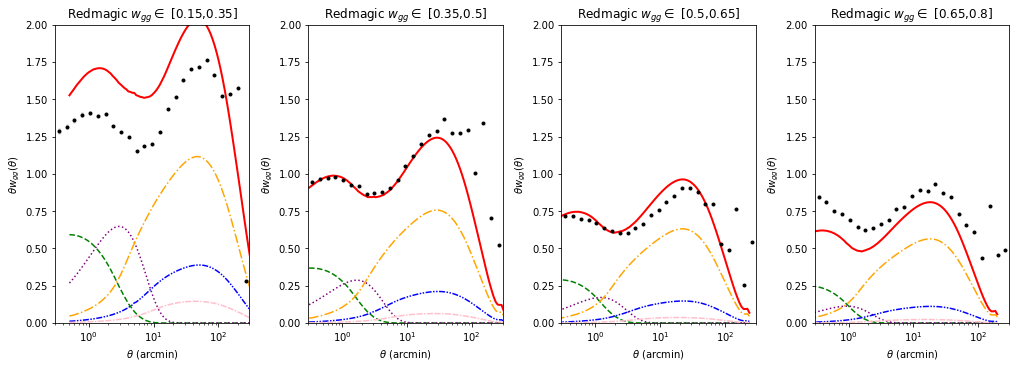

In [35]:
def plot_wp_hod(wp_redmagic, zbins, hod, fudge_factor=450.) :

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14, 5), constrained_layout=True)
    
    for i in range(0,len(zbins)) :
        zbin = zbins[i]
        zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)
        
        df = wp_redmagic[zavg]
        wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
        varwp = varwp*theta
        wp    =    wp*theta
    
        ax[i].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
            elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))
        
        zavg = (zbin[0]+zbin[1])/2.
        Dc = cosmo.arcsec_per_kpc_comoving(zavg)
        Dp = cosmo.arcsec_per_kpc_proper(zavg)

        arcmin_per_mpc = Dc.value*(1e3/60.)
        rs = np.logspace(-1,2,100)
        thetas = rs*arcmin_per_mpc/0.68  # Dark Quest emulator gives comoving radii with units of Mpc/h
        thetas2=thetas/fudge_factor
        ax[i].plot(thetas, thetas2*hod.get_wp(rs, zavg), linewidth = 2, color = "r", label = "total")
        ax[i].plot(thetas, thetas2*hod.get_wp_1hcs(rs, zavg), "--", color = "g", label = "1-halo cen-sat")
        ax[i].plot(thetas, thetas2*hod.get_wp_1hss(rs, zavg), ":", color = "purple", label = "1-halo sat-sat")
        ax[i].plot(thetas, thetas2*hod.get_wp_2hcc(rs, zavg), "-.", color = "orange", label = "2-halo cen-cen")
        ax[i].plot(thetas, thetas2*hod.get_wp_2hcs(rs, zavg), dashes=[4,1,1,1,1,1], color = "b", label = "2-halo cen-sat")
        ax[i].plot(thetas, thetas2*hod.get_wp_2hss(rs, zavg), dashes=[4,1,1,1,4,1], color = "pink", label = "2-halo sat-sat")
    
        ax[i].set_xlim(0.3,300)
        ax[i].set_ylim(0,2.)
        ax[i].set_xscale('log')
        ax[i].set_title(r'Redmagic $w_{gg} \in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']')
        ax[i].set_xlabel(r'$\theta$ (arcmin)')
        ax[i].set_ylabel(r'$\theta w_{gg}(\theta)$ ')
        #ax[i].legend()

plot_wp_hod(wp_redmagic, zbins, hod)

## 4.3 The Redmagic autocorr and the ACT cluster -- Redmagic galaxy cross correlation

### 4.3.1 Galaxy HOD

In [27]:
cparam = np.array([0.02225,0.1198,0.6844,3.094,0.9645,-1.])
hod1 = model_hod.darkemu_x_hod({'fft_num':8})
hod1.set_cosmology(cparam)
# from G Zacharegkas et. al
#gparam = {"logMmin":12.03, "sigma_sq":0.1156, "logM1": 13.79, "alpha": 1.75, "kappa": 0.0, # HOD parameters
gparam = {"logMmin":12.90, "sigma_sq":0.1156, "logM1": 14.0, "alpha": 1.35, "kappa": 0., # HOD parameters
           "poff":0.2 , "Roff":0.20, # off-centering parameters p_off is the fraction of off-centered galaxies. Roff is the typical off-centered scale with respect to R200m.
           "sat_dist_type": "emulator", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
           #"sat_dist_type": "NFW", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
           "alpha_inc": 0.0, "logM_inc": 0.0} # incompleteness parameters. For details, see More et al. (2015)
hod1.set_galaxy(gparam)

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


### 4.3.2 Cluster HOD  and plot

In [45]:
def plot_cross_wp_hod(wp_redmagic, wp_act, zbins, y_bins, hod1, hod2, fudge_factor=450.) :

    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(14, 15), constrained_layout=True)
    
    for i in range(0,len(zbins)) :
        zbin = zbins[::-1][i]
        zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)        
        df = wp_redmagic[zavg]
        wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
        varwp = varwp*theta
        wp    =    wp*theta
    
        j=0
        ax[i][j].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
            elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))
            
        zavg = (zbin[0]+zbin[1])/2.
        Dc = cosmo.arcsec_per_kpc_comoving(zavg)
        Dp = cosmo.arcsec_per_kpc_proper(zavg)

        arcmin_per_mpc = Dc.value*(1e3/60.)
        #rs = np.logspace(-1,2,100)
        rs = np.linspace(0.3,10,100)
        thetas = rs*arcmin_per_mpc/0.68  # Dark Quest emulator gives comoving radii with units of Mpc/h
        thetas2=thetas/fudge_factor
        ax[i][j].plot(thetas, thetas2*hod1.get_wp(rs, zavg), linewidth = 2, color = "r", label = "total")
        ax[i][j].plot(thetas, thetas2*hod1.get_wp_1hcs(rs, zavg), "--", color = "g", label = "1-halo cen-sat")
        ax[i][j].plot(thetas, thetas2*hod1.get_wp_1hss(rs, zavg), ":", color = "purple", label = "1-halo sat-sat")
        ax[i][j].plot(thetas, thetas2*hod1.get_wp_2hcc(rs, zavg), "-.", color = "orange", label = "2-halo cen-cen")
        ax[i][j].plot(thetas, thetas2*hod1.get_wp_2hcs(rs, zavg), dashes=[4,1,1,1,1,1], color = "b", label = "2-halo cen-sat")
        ax[i][j].plot(thetas, thetas2*hod1.get_wp_2hss(rs, zavg), dashes=[4,1,1,1,4,1], color = "pink", label = "2-halo sat-sat")

        ax[i][j].set_xlim(0.3,100)
        ax[i][j].set_ylim(0.3,30)
        ax[i][j].set_xscale('log')
        ax[i][j].set_yscale('log')
        ax[i][j].set_title(r'RedGal $w_{gg} \in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']')
        ax[i][j].set_xlabel(r'$\theta$ (arcmin)')
        ax[i][j].set_ylabel(r'$\theta w_gg(\theta)$ ')
        
        bin_count = 0  
        for j in range(1,len(y_bins)+1) :
            zbin = zbins[::-1][i]
            zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)
            y_bin_name = bin_count
        
            df = wp_act[zavg, y_bin_name]
            wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
            varwp = varwp*theta
            wp    =    wp*theta
    
            ax[i][j].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
            elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))
        
            if j == 1:
                logMmin = 14.1
                var = 0.12
                alpha = 1.5
            elif j == 2:
                logMmin = 14.05
                var = 0.12
                alpha = 1.5
            elif j == 3:
                logMmin = 14.15
                var = 0.12
                alpha = 1.5
            logM1 = 14.3
            logM1 = 14.5
            logM1 = 14.7

            gparam = {"logMmin":logMmin, "sigma_sq":var, "logM1": logM1, "alpha": alpha, "kappa": 0., # HOD parameters
               "poff":0.10 , "Roff":0.25, # off-centering parameters p_off is the fraction of off-centered galaxies. Roff is the typical off-centered scale with respect to R200m.
               "sat_dist_type": "emulator", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
               "alpha_inc": 0.0, "logM_inc": 0.0} # incompleteness parameters. For details, see More et al. (2015)
            hod2.set_galaxy(gparam)
            
            #thetas2=thetas2*2.0
            zavg = (zbin[0]+zbin[1])/2.
            one_cen_sat = hod2.get_wp_1hcs(rs, zavg)
            one_sat_sat = hod2.get_wp_1hss(rs, zavg)
            two_cen_cen = hod2.get_wp_2hcc(rs, zavg)
            two_cen_sat = hod2.get_wp_2hcs(rs, zavg)
            two_sat_sat = hod2.get_wp_2hss(rs, zavg)
            total = one_cen_sat + one_sat_sat + two_cen_cen + two_cen_sat + two_sat_sat
            ax[i][j].plot(thetas, thetas2*total, linewidth = 2, color = "r", label = "total")
            ax[i][j].plot(thetas, thetas2*one_cen_sat, "--", color = "g", label = "1-halo cen-sat")
            ax[i][j].plot(thetas, thetas2*one_sat_sat, ":", color = "purple", label = "1-halo sat-sat")
            ax[i][j].plot(thetas, thetas2*two_cen_cen, "-.", color = "orange", label = "2-halo cen-cen")
            ax[i][j].plot(thetas, thetas2*two_cen_sat, dashes=[4,1,1,1,1,1], color = "b", label = "2-halo cen-sat")
            ax[i][j].plot(thetas, thetas2*two_sat_sat, dashes=[4,1,1,1,4,1], color = "pink", label = "2-halo sat-sat")

            #ax[i][j].set_xlim(0.3,300)
            ax[i][j].set_xlim(0.3,100)
            ax[i][j].set_ylim(0.3,30)
            ax[i][j].set_xscale('log')
            ax[i][j].set_yscale('log')
            ax[i][j].set_title(r'ActCl $w_{cg} \in$' 
                                + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']' 
                               + "   Y-bin "+ str(y_bin_name) )
            ax[i][j].set_xlabel(r'$\theta$ (arcmin)')
            ax[i][j].set_ylabel(r'$\theta w_{cg}(\theta)$ ')
            
            bin_count += 1

hod2 = model_hod.darkemu_x_hod({'fft_num':8})
hod2.set_cosmology(cparam)


initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


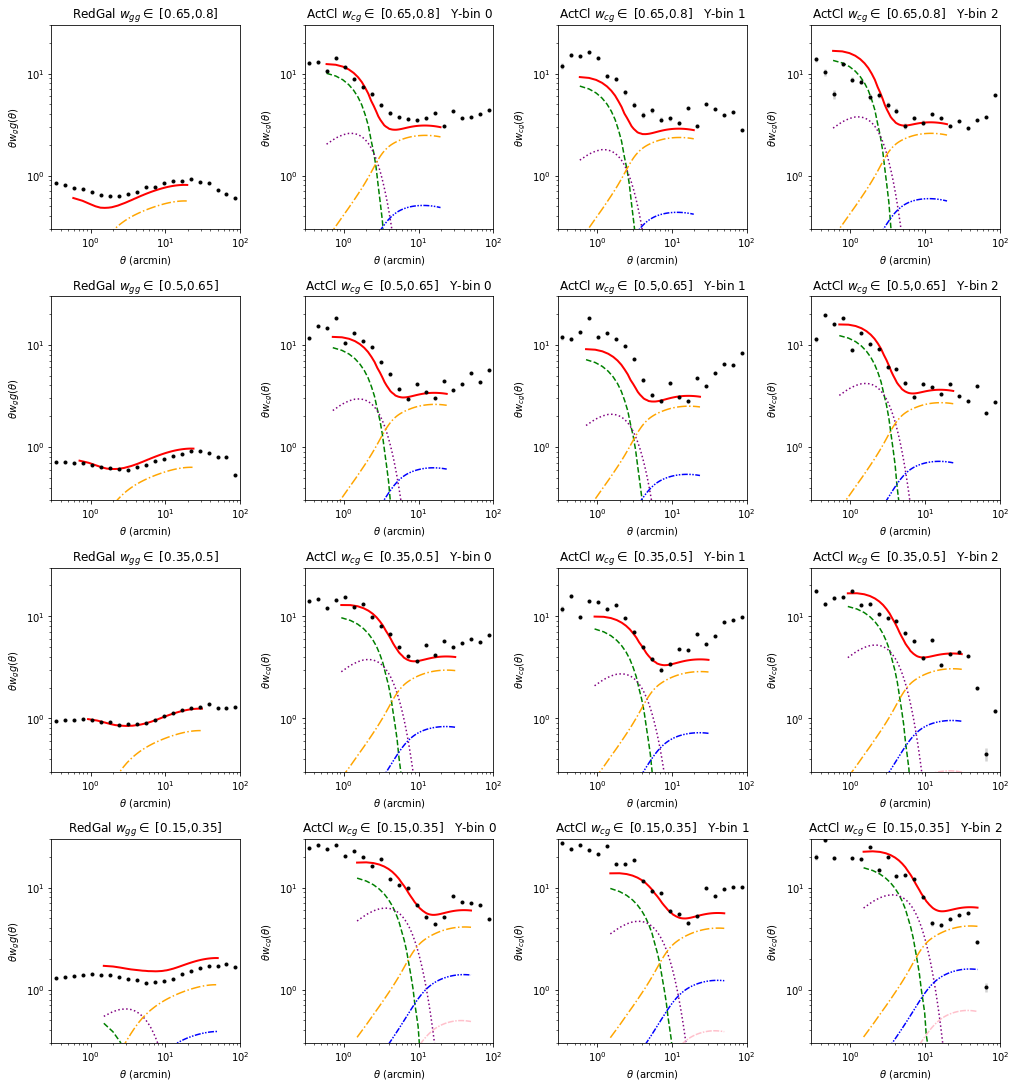

In [46]:
plot_cross_wp_hod(wp_redmagic, wp_act, zbins, y_bins, hod1, hod2)

### 4.3.3 Cluster HOD  and plot, focusing on the z=[0.35,0.5]

In [140]:
def plot_cross_wp_hod_z(wp_act, zbins, y_bins, hods, fudge_factor=450.) :

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 7), constrained_layout=True)
    
#   for i in range(0,len(zbins)) :
    for i in [2,] :
        zbin = zbins[::-1][i]
        zavg = (zbin[0]+zbin[1])/2.   
        
        Dc = cosmo.arcsec_per_kpc_comoving(zavg)
        Dp = cosmo.arcsec_per_kpc_proper(zavg)
        zavg = "{:3.2f}".format(zavg) 

        arcmin_per_mpc = Dc.value*(1e3/60.)
        #rs = np.logspace(-1,2,100)
        rs = np.linspace(0.3,10,100)
        thetas = rs*arcmin_per_mpc/0.68  # Dark Quest emulator gives comoving radii with units of Mpc/h
        thetas2=thetas/fudge_factor
        
        bin_count = 0  
        for j in range(0,len(y_bins)) :
            zbin = zbins[::-1][i]
            zavg = (zbin[0]+zbin[1])/2.  ; zavg = "{:3.2f}".format(zavg)
            y_bin_name = bin_count
        
            df = wp_act[zavg, y_bin_name]
            wp,varwp,theta = df["wp"], df["varwp"], df["theta"]
            varwp = varwp*theta
            wp    =    wp*theta
    
            ax[j].errorbar(theta,wp,np.sqrt(varwp),fmt='.', color='black', ecolor='lightgrey',
                elinewidth=2.5, label = ('z' +  r'$\in$' + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']'))

            hod = hods[j];            
            #print(hod.gparams)
            if j == 0:
                print ("logMmin {}  sigma_sq {} alpha {} logM1 {}".format(hods[0].gparams["logMmin"], hods[0].gparams["sigma_sq"], 
                             hods[0].gparams["alpha"], hods[0].gparams["logM1"]))
          
            zavg = (zbin[0]+zbin[1])/2.
            one_cen_sat = hod.get_wp_1hcs(rs, zavg)
            one_sat_sat = hod.get_wp_1hss(rs, zavg)
            two_cen_cen = hod.get_wp_2hcc(rs, zavg)
            two_cen_sat = hod.get_wp_2hcs(rs, zavg)
            two_sat_sat = hod.get_wp_2hss(rs, zavg)
            total = one_cen_sat + one_sat_sat + two_cen_cen + two_cen_sat + two_sat_sat
            ax[j].plot(thetas, thetas2*total, linewidth = 2, color = "r", label = "total")
            ax[j].plot(thetas, thetas2*one_cen_sat, "--", color = "g", label = "1-halo cen-sat")
            ax[j].plot(thetas, thetas2*one_sat_sat, ":", color = "purple", label = "1-halo sat-sat")
            ax[j].plot(thetas, thetas2*two_cen_cen, "-.", color = "orange", label = "2-halo cen-cen")
            ax[j].plot(thetas, thetas2*two_cen_sat, dashes=[4,1,1,1,1,1], color = "b", label = "2-halo cen-sat")
            ax[j].plot(thetas, thetas2*two_sat_sat, dashes=[4,1,1,1,4,1], color = "pink", label = "2-halo sat-sat")

            ax[j].set_xlim(0.3,100)
            ax[j].set_ylim(0.3,30)
            ax[j].set_xscale('log')
            ax[j].set_yscale('log')
            ax[j].set_title(r'ActCl $w_{cg} \in$' 
                                + ' [' + str(zbin[0]) + ',' + str(zbin[1]) + ']' 
                               + "   Y-bin "+ str(y_bin_name) )
            ax[j].set_xlabel(r'$\theta$ (arcmin)')
            ax[j].set_ylabel(r'$\theta w_{cg}(\theta)$ ')
            
            bin_count += 1


In [136]:
def make_hod_model(gparam, cparam) :
    hod = model_hod.darkemu_x_hod({'fft_num':8})
    hod.set_cosmology(cparam)
    hod.set_galaxy(gparam)
    return hod

In [138]:
logMmin = 14.1
var = 0.12
alpha = 1.5
logM1 = 14.7
gparam = {"logMmin":logMmin, "sigma_sq":var, "logM1": logM1, "alpha": alpha, "kappa": 0., # HOD parameters
               "poff":0.10 , "Roff":0.25, # off-centering parameters p_off is the fraction of off-centered galaxies. Roff is the typical off-centered scale with respect to R200m.
               "sat_dist_type": "emulator", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
               "alpha_inc": 0.0, "logM_inc": 0.0} # incompleteness parameters. For details, see More et al. (2015)

g1_param = gparam.copy()
g2_param = gparam.copy()
g3_param = gparam.copy()

hod1 = make_hod_model(gparam, cparam)
hod2 = make_hod_model(gparam, cparam)
hod3 = make_hod_model(gparam, cparam)

hods = [hod1, hod2, hod3]

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


#### 4.3.3.1 Default HOD

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


logMmin 14.1  sigma_sq 0.12 alpha 1.5 logM1 14.7


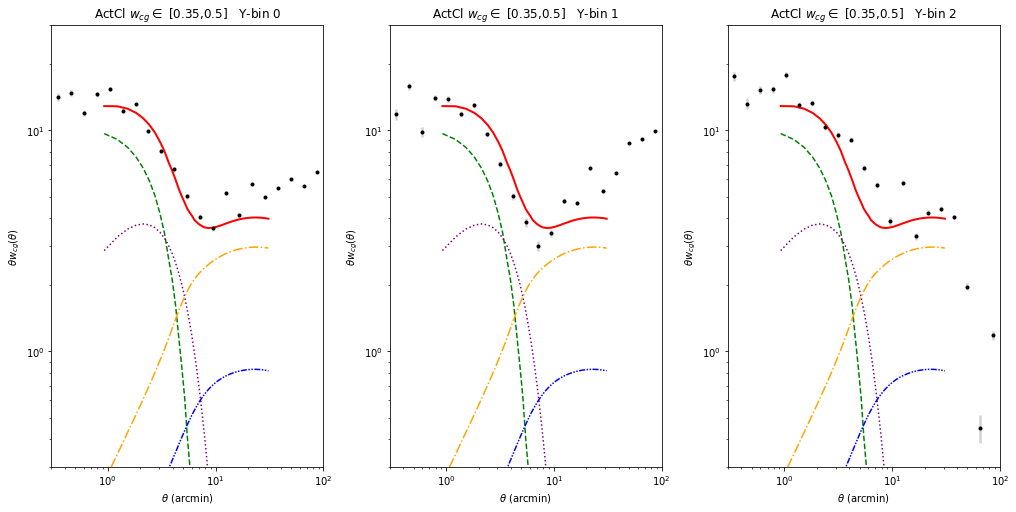

In [141]:
g1_param["logMmin"] = 14.1
g1_param["sigma_sq"] = 0.12
hod1 = make_hod_model(g1_param, cparam)
hods = [hod1, hod2, hod3]
plot_cross_wp_hod_z(wp_act, zbins, y_bins, hods) ;# 14.1 0.12

#### 4.3.3.2 Lowering variance increases sharpness of 1-halo term

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


logMmin 14.1  sigma_sq 0.05 alpha 1.5 logM1 14.7


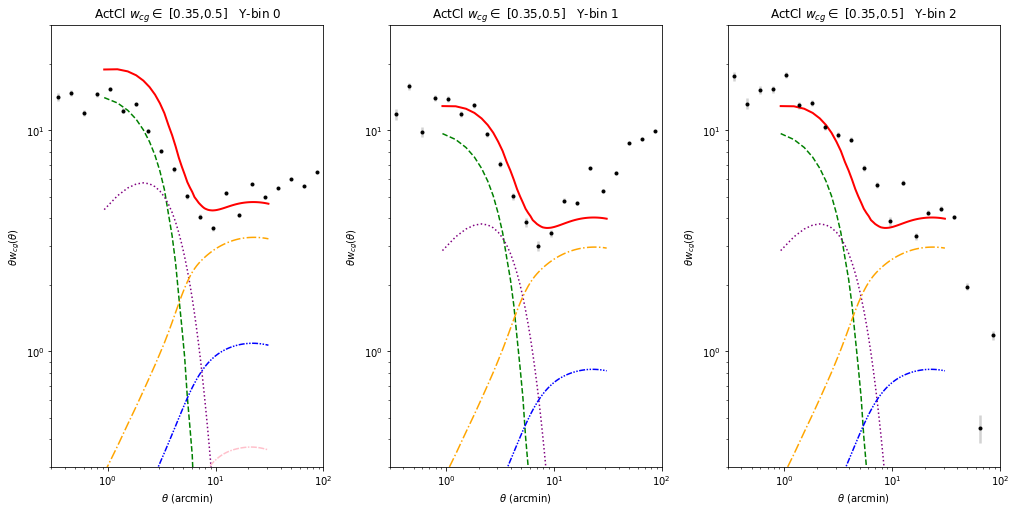

In [143]:
g1_param["logMmin"] = 14.1
g1_param["sigma_sq"] = 0.05
hod10 = make_hod_model(g1_param, cparam)
hods = [hod10, hod2, hod3]
plot_cross_wp_hod_z(wp_act, zbins, y_bins, hods) ;# 14.1 0.05

#### 4.3.3.3 Which can be balanced by lowering mass, logMmin

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


logMmin 14.05  sigma_sq 0.05 alpha 1.5 logM1 14.7


{'logMmin': 14.05,
 'sigma_sq': 0.05,
 'logM1': 14.7,
 'alpha': 1.5,
 'kappa': 0.0,
 'poff': 0.1,
 'Roff': 0.25,
 'sat_dist_type': 'emulator',
 'alpha_inc': 0.0,
 'logM_inc': 0.0}

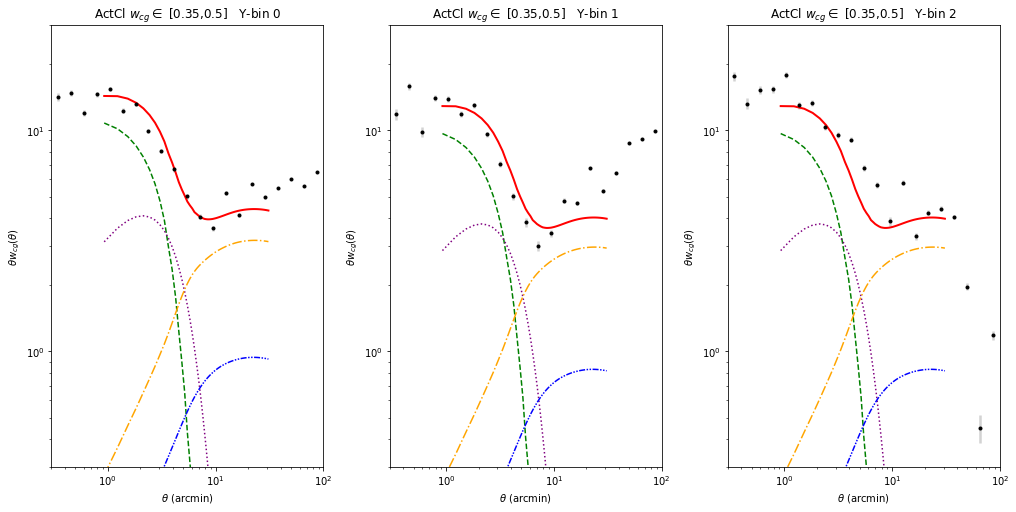

In [144]:
g1_param["logMmin"] = 14.05
g1_param["sigma_sq"] = 0.05
hod11 = make_hod_model(g1_param, cparam)
hods = [hod11, hod2, hod3]
plot_cross_wp_hod_z(wp_act, zbins, y_bins, hods) ;# 14.05 0.05
hods[0].gparams

#### 4.3.3.4 Changing alpha changes satellite contributions to 1-halo and 2-halo

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


logMmin 14.05  sigma_sq 0.05 alpha 1.75 logM1 14.7


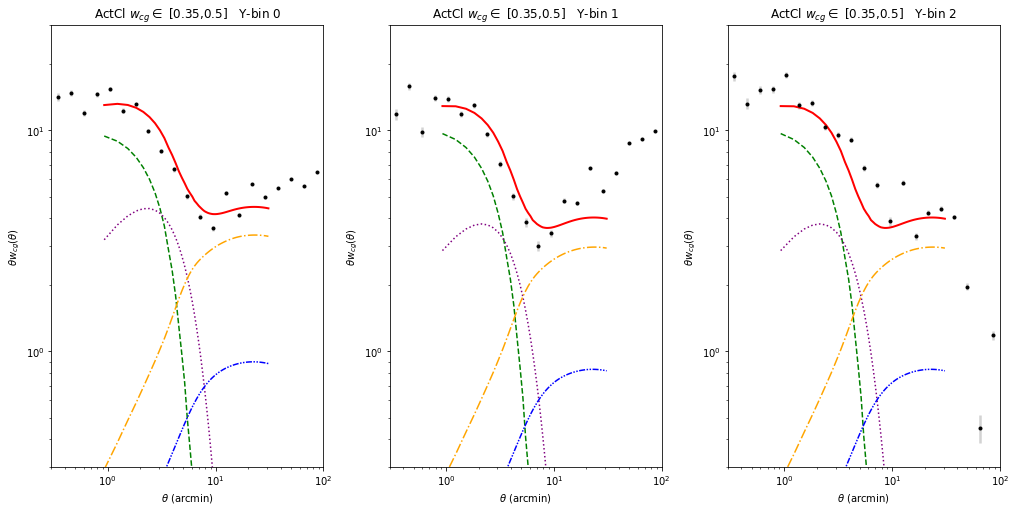

In [153]:
g1_param["logMmin"] = 14.05
g1_param["sigma_sq"] = 0.05
g1_param["alpha"] = 1.75
hod11 = make_hod_model(g1_param, cparam)
hods = [hod11, hod2, hod3]
plot_cross_wp_hod_z(wp_act, zbins, y_bins, hods) ;

#### 4.3.4 Find HOD that describes bin 0, then change only mass for bin 1 and bin 2

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


INFO:root:Got same cosmology. Keep quantities already computed.


logMmin 14.03  sigma_sq 0.05 alpha 1.5 logM1 14.7


{'logMmin': 14.03,
 'sigma_sq': 0.05,
 'logM1': 14.7,
 'alpha': 1.5,
 'kappa': 0.0,
 'poff': 0.1,
 'Roff': 0.25,
 'sat_dist_type': 'emulator',
 'alpha_inc': 0.0,
 'logM_inc': 0.0}

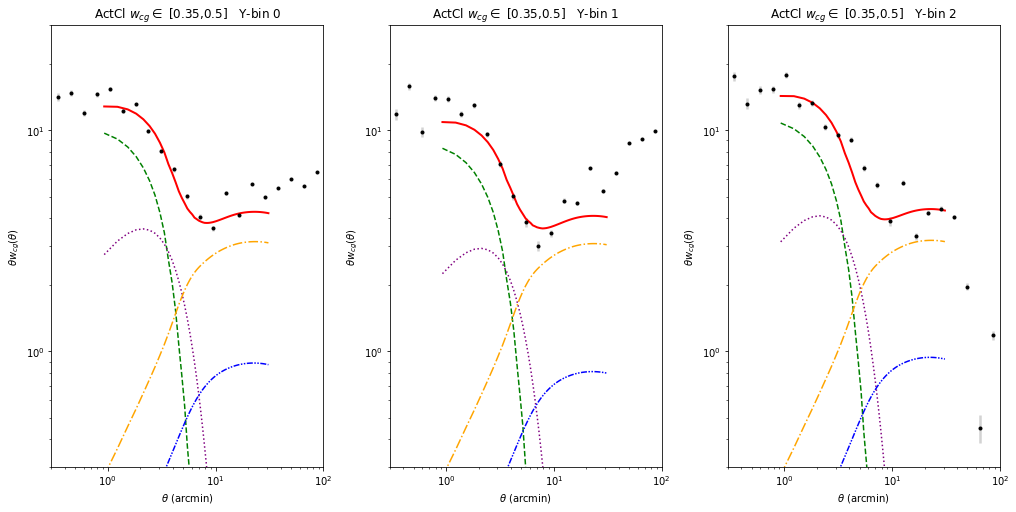

In [152]:
g1_param["logMmin"] = 14.03
g1_param["sigma_sq"] = 0.05
g1_param["alpha"] = 1.50
g1_param["logM1"] = 14.7
g1_param["poff"] = 0.1
hod12 = make_hod_model(g1_param, cparam)

g2_param = g1_param.copy()
g2_param["logMmin"] = 14.0
hod21 = make_hod_model(g2_param, cparam)

g3_param = g1_param.copy()
g3_param["logMmin"] = 14.05
hod31 = make_hod_model(g3_param, cparam)

hods = [hod12, hod21, hod31]
plot_cross_wp_hod_z(wp_act, zbins, y_bins, hods) ;
hods[0].gparams